In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder  # LabelEncoder hinzufügen
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import time


In [42]:
# Cuda check
print(f"CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: True
Using device: cuda


In [25]:
# Embeddings laden
embeddings_path = "../data/esmc-embeddings/embeddings_complete.npz"
data = np.load(embeddings_path, allow_pickle=True)

# Embeddings und Labels extrahieren
X = data['embeddings']
Y = data['labels']

print(f"Shape of embeddings: {X.shape}")
print(f"Shape of labels: {Y.shape}")
print("Anzahl der Klassen:", len(np.unique(Y)))

Shape of embeddings: (1250, 31, 960)
Shape of labels: (1250,)
Anzahl der Klassen: 3


In [43]:
# 6B Modell Embeddings laden
embeddings_path = "../data/esmc-embeddings/embeddings_complete_6B_55.npz"
data = np.load(embeddings_path, allow_pickle=True)

# Embeddings und Labels extrahieren
X = data['embeddings']
Y = data['labels']

print(f"Shape of embeddings: {X.shape}")
print(f"Shape of labels: {Y.shape}")
print("Anzahl der Klassen:", len(np.unique(Y)))

Shape of embeddings: (1250, 2560)
Shape of labels: (1250,)
Anzahl der Klassen: 3


In [26]:
# Extrahieren der verschiedenen Layer-Features

# 1. Frühes Layer
X_early = X[:, 0, :]
print("Shape des frühen Layers:", X_early.shape)

# 2. Mittleres Layer
middle_idx = X.shape[1] // 2
X_middle = X[:, middle_idx, :]
print("Shape des mittleren Layers:", X_middle.shape)

# 3. Spätes Layer
X_late = X[:, -1, :]
print("Shape des späten Layers:", X_late.shape)

# 4. Durchschnitt über alle drei Ansätze
X_avg = np.mean(np.stack([X_early, X_middle, X_late]), axis=0)
print("Shape des gemittelten Layers:", X_avg.shape)

Shape des frühen Layers: (1250, 960)
Shape des mittleren Layers: (1250, 960)
Shape des späten Layers: (1250, 960)
Shape des gemittelten Layers: (1250, 960)


# Labeel-Encoding

In [44]:
# Label-Konvertierung zu numerischen Indizes
from sklearn.preprocessing import LabelEncoder

# LabelEncoder für String-Labels zu numerischen Indizes
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

print(f"Original Labels: {Y[:5]}")
print(f"Encoded Labels: {Y_encoded[:5]}")
print(f"Label-Klassen: {label_encoder.classes_}")
print(f"Anzahl der Klassen: {len(label_encoder.classes_)}")

Original Labels: ['late' 'late' 'middle' 'late' 'late']
Encoded Labels: [1 1 2 1 1]
Label-Klassen: ['early' 'late' 'middle']
Anzahl der Klassen: 3


In [45]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(MLP, self).__init__()

        layers = []

        # Input zum ersten Hidden Layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden Layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output Layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Sequential Container
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [46]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device=device):
    model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        # Metriken berechnen
        train_loss_avg = train_loss / len(train_loader)
        train_acc      = 100 * train_correct / train_total
        val_loss_avg   = val_loss / len(val_loader)
        val_acc        = 100 * val_correct / val_total

        # Learning Rate anpassen (ReduceLROnPlateau erwartet hier das Val-Loss)
        scheduler.step(val_loss_avg)

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 25 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {current_lr:.6f}')
            print(f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 50)

    return train_losses, train_accuracies, val_losses, val_accuracies

 # Evaluierungs-Funktion


In [47]:
def evaluate_model_with_labels(model, X_test, y_test, label_encoder, device=device):
    model.eval()
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)

        # Zurück zu CPU für sklearn-Metriken
        y_test_cpu = y_test.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()

        # Accuracy berechnen
        test_accuracy = accuracy_score(y_test_cpu, predicted_cpu)

        # Confusion Matrix mit originalen Label-Namen
        cm = confusion_matrix(y_test_cpu, predicted_cpu)
        cr = classification_report(
            y_test_cpu,
            predicted_cpu,
            target_names=label_encoder.classes_
        )

        return test_accuracy, cm, cr, predicted_cpu

# Haupttraining für alle Feature-Sets

In [9]:
# Feature-Sets definieren
feature_sets = {
    "Frühes Layer": X_early,
    "Mittleres Layer": X_middle,
    "Spätes Layer": X_late,
    "Gemittelt": X_avg
}

# Hyperparameter (verbessert)
input_size = 960
hidden_sizes = [512, 256, 128, 64]
output_size = len(label_encoder.classes_)  # Verwende bereits erstellten encoder
learning_rate = 0.001
batch_size = 32
num_epochs = 200
dropout_rate = 0.2

results = {}

# Jedes Feature-Set trainieren
for name, features in feature_sets.items():
    print(f"\n{'=' * 60}")
    print(f"Training mit {name}")
    print(f"{'=' * 60}")

    start_time = time.time()

    # Daten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(
        features, Y_encoded, test_size=0.25, random_state=42
    )

    # Weitere Aufteilung für Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Standardisierung
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Zu PyTorch Tensoren konvertieren
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)

    # DataLoader erstellen
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Modell erstellen
    model = MLP(input_size, hidden_sizes, output_size, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

    print(f"Modell-Architektur:")
    print(model)
    print(f"Trainierbare Parameter: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Training
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )

    # Test-Evaluation (KORRIGIERT!)
    test_accuracy, cm, cr, predictions = evaluate_model_with_labels(
        model, X_test_tensor, y_test_tensor, label_encoder, device
    )

    duration = time.time() - start_time
    print(f"\nTraining dauerte {duration:.2f} Sekunden")
    print(f"Test-Genauigkeit: {test_accuracy:.4f}")

    # Ergebnisse speichern
    results[name] = {
        "accuracy": test_accuracy,
        "model": model,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "scaler": scaler,
        "confusion_matrix": cm,
        "classification_report": cr
    }

    # Modell speichern
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'label_encoder': label_encoder,
        'model_config': {
            'input_size': input_size,
            'hidden_sizes': hidden_sizes,
            'output_size': output_size,
            'dropout_rate': dropout_rate
        }
    }, f'pytorch_mlp_{name.replace(" ", "_").lower()}.pth')

    print(f"Modell wurde als 'pytorch_mlp_{name.replace(' ', '_').lower()}.pth' gespeichert")

NameError: name 'X_early' is not defined

# 6B Modell Embedding MLP Training

In [37]:
# Hyperparameter angepasst für die neue Embedding-Größe
input_size = 2560  # Neue Feature-Dimension
hidden_sizes = [512, 256, 128, 64]
output_size = len(label_encoder.classes_)
learning_rate = 0.001
batch_size = 32
num_epochs = 200
dropout_rate = 0.3
weight_decay = 1e-3
patience = 20 # Early Stopping Geduld

print(f"\n{'=' * 60}")
print(f"Training mit ESMC 6B Embedding – verbesserte Versio")
print(f"{'=' * 60}")

start_time = time.time()

# 1) Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.25, random_state=42, stratify=Y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2) Standardisierung
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 3) zu PyTorch-Tensoren konvertieren

X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor   = torch.from_numpy(X_val_scaled).float()
y_val_tensor   = torch.from_numpy(y_val).long()
X_test_tensor  = torch.from_numpy(X_test_scaled).float()
y_test_tensor  = torch.from_numpy(y_test).long()


# 4) Klassengewichte & Sampler
counts       = np.bincount(y_train)                # [#early, #late, #middle]
inv_freq     = 1.0 / counts
sample_weights = inv_freq[y_train]
sampler      = WeightedRandomSampler(sample_weights,
                                     num_samples=len(sample_weights),
                                     replacement=True)

# 5) Dataset & DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)

# Variante A: Loss-Weighting
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# # Variante B: Sampler-Weighting (statt Loss-Weighting)
# sample_weights = inv_freq[y_train]
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
# criterion    = nn.CrossEntropyLoss()

# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 6) Modell erstellen und auf GPU/CPU verschieben
model = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("Modell-Architektur:\n", model)
print(f"Trainierbare Parameter: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 7) Training
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs, device
)

# 8) Test-Evaluation
test_accuracy, cm, cr, predictions = evaluate_model_with_labels(
    model, X_test_tensor.to(device), y_test_tensor.to(device),
    label_encoder, device
)

duration = time.time() - start_time
print(f"\nTraining dauerte {duration:.2f} Sekunden")
print(f"Test-Genauigkeit: {test_accuracy:.4f}")

# Ergebnisse speichern
results = {
    "Embedding": {
        "accuracy": test_accuracy,
        "model": model,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "scaler": scaler,
        "confusion_matrix": cm,
        "classification_report": cr
    }
}

# Classification Report ausgeben
print("\nClassification Report:")
print(results['Embedding']['classification_report'])


Training mit ESMC 6B Embedding – verbesserte Versio
Modell-Architektur:
 MLP(
  (network): Sequential(
    (0): Linear(in_features=2560, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)
Trainierbare Parameter: 3,319,939


TypeError: ReduceLROnPlateau.step() missing 1 required positional argument: 'metrics'

In [48]:
# ---  Hyperparameter  ---
input_size    = 2560
hidden_sizes  = [1024, 512, 256, 128, 64]
output_size   = len(label_encoder.classes_)
learning_rate = 1e-3
batch_size    = 32
num_epochs    = 200
dropout_rate  = 0.3        # erhöhtes Dropout
weight_decay  = 1e-3       # stärkere L2-Regularisierung
patience      = 20         # EarlyStopping-Geduld auf Macro-F1
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n" + "="*60)
print("Training mit ESMC 6B Embedding – verbesserte Version")
print("="*60, "\n")

start_time = time.time()

# 1) Daten splitten (mit Stratify!)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.25, random_state=42, stratify=Y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2) Standardisieren
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 3) Torch-Tensoren
X_train_t = torch.from_numpy(X_train_s).float()
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val_s).float()
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test_s).float()
y_test_t  = torch.from_numpy(y_test).long()

# 4) Klassengewichte & Sampler
counts       = np.bincount(y_train)                # [#early, #late, #middle]
inv_freq     = 1.0 / counts
sample_weights = inv_freq[y_train]
sampler      = WeightedRandomSampler(sample_weights,
                                     num_samples=len(sample_weights),
                                     replacement=True)

# 5) DataLoader
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

# 6) Modell, Loss, Optimizer, Scheduler
model     = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# # a) Klassisches weighted CrossEntropy
# class_weights = torch.from_numpy(inv_freq / inv_freq.sum() * len(counts))\
#                     .float().to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# b) Optional: Focal Loss statt CrossEntropy
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce)
        loss = ((1 - p_t) ** self.gamma * ce).mean()
        return loss
criterion = FocalLoss(alpha=class_weights, gamma=2.0)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Modell-Architektur:\n", model)
print(f"Trainierbare Parameter: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

# 7) Trainingsloop mit Early Stopping auf Macro-F1
best_macro_f1 = 0.0
epochs_no_imp = 0

for epoch in range(1, num_epochs+1):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb.to(device))
        loss   = criterion(logits, yb.to(device))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb.to(device))
            preds  = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(yb.numpy())

    macro_f1 = f1_score(all_true, all_preds, average='macro')
    scheduler.step(macro_f1)

    print(f"Epoch [{epoch}/{num_epochs}]  Val Macro-F1: {macro_f1:.4f}  LR: {optimizer.param_groups[0]['lr']:.1e}")

    # Early Stopping
    if macro_f1 > best_macro_f1 + 1e-4:
        best_macro_f1 = macro_f1
        epochs_no_imp = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_imp += 1

    if epochs_no_imp >= patience:
        print(f"Early stopping nach {epoch} Epochen (keine Verbesserung).")
        break

duration = time.time() - start_time
print(f"\nTraining abgeschlossen in {duration:.1f} s, bester Val Macro-F1: {best_macro_f1:.4f}\n")

# 8) Bestes Modell laden & Test-Evaluation
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device))
    preds  = torch.argmax(logits, dim=1).cpu().numpy()

from sklearn.metrics import classification_report, confusion_matrix
print("Test Classification Report:")
print(classification_report(y_test, preds, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))



Training mit ESMC 6B Embedding – verbesserte Version

Modell-Architektur:
 MLP(
  (network): Sequential(
    (0): Linear(in_features=2560, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)
Trainierbare Parameter: 3,319,939

Epoch [1/200]  Val Macro-F1: 0.3352  LR: 1.0e-03
Epoch [2/200]  Val Macro-F1: 0.3709  LR: 1.0e-03
Epoch [3/200]  Val Macro-F1: 0.3202  LR: 1.0e-03
Epoch [4/200]  Val Macro-F1: 0.3999  LR: 1.0e-03
Epoch

In [49]:
# Zelle: Ensemble-Training und Soft-Voting

import copy
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

# FocalLoss (oder nutze CrossEntropyLoss, je nachdem)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.alpha, reduction='none')
        p_t = torch.exp(-ce)
        loss = (1 - p_t)**self.gamma * ce
        if self.reduction=='mean': return loss.mean()
        if self.reduction=='sum':  return loss.sum()
        return loss

# Funktion zum Training eines einzelnen Modells
def train_single_model(seed):
    torch.manual_seed(seed); np.random.seed(seed)
    model_i = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
    opt_i   = torch.optim.Adam(model_i.parameters(), lr=learning_rate, weight_decay=weight_decay)
    crit_i  = FocalLoss(alpha=class_weights, gamma=2.0)  # oder nn.CrossEntropyLoss(weight=class_weights)
    sched_i = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_i, mode='max', factor=0.5, patience=5)

    best_f1, no_imp = 0.0, 0
    best_state = None
    for epoch in range(1, num_epochs+1):
        model_i.train()
        for xb,yb in train_loader:
            opt_i.zero_grad()
            loss = crit_i(model_i(xb.to(device)), yb.to(device))
            loss.backward(); opt_i.step()
        # Validation
        model_i.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb,yb in val_loader:
                out = model_i(xb.to(device))
                preds.extend(torch.argmax(out,1).cpu().numpy())
                trues.extend(yb.numpy())
        mac_f1 = f1_score(trues, preds, average='macro')
        sched_i.step(mac_f1)
        if mac_f1 > best_f1 + 1e-4:
            best_f1, no_imp = mac_f1, 0
            best_state = copy.deepcopy(model_i.state_dict())
        else:
            no_imp += 1
        if no_imp >= patience:
            break
    model_i.load_state_dict(best_state)
    return model_i

# 1) Ensemble-Modelle trainieren
seeds = [0,1,2,3,4]
models = [train_single_model(s) for s in seeds]

# 2) Soft-Voting Vorhersage
def ensemble_predict(models, X_tensor):
    probs = []
    with torch.no_grad():
        for m in models:
            m.eval()
            # Detach, bevor .numpy() aufgerufen wird
            p = F.softmax(m(X_tensor.to(device)), dim=1).detach().cpu().numpy()
            probs.append(p)
    avg_probs = np.mean(probs, axis=0)
    return np.argmax(avg_probs, axis=1)


y_pred_ens = ensemble_predict(models, X_test_tensor)

# 3) Auswertung
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ens, target_names=label_encoder.classes_))
print("Ensemble Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ens))


Ensemble Classification Report:
              precision    recall  f1-score   support

       early       0.56      0.50      0.53       130
        late       0.48      0.49      0.49       104
      middle       0.38      0.43      0.40        79

    accuracy                           0.48       313
   macro avg       0.47      0.47      0.47       313
weighted avg       0.49      0.48      0.48       313

Ensemble Confusion Matrix:
[[65 32 33]
 [30 51 23]
 [22 23 34]]


# Grid-Search für Hyperparameter-Optimierung

In [11]:
import itertools
from sklearn.model_selection import KFold

def grid_search_mlp(X, Y, param_grid, n_splits=3, random_state=42):
    # Ergebnisse speichern
    grid_results = []

    # KFold für Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Alle Parameterkombinationen erstellen
    param_combinations = list(itertools.product(
        param_grid['hidden_sizes'],
        param_grid['dropout_rates'],
        param_grid['learning_rates'],
        param_grid['weight_decays'],
        param_grid['batch_sizes']
    ))

    total_combinations = len(param_combinations)
    print(f"Insgesamt {total_combinations} Parameterkombinationen zu testen")

    for i, (hidden_sizes, dropout_rate, lr, weight_decay, batch_size) in enumerate(param_combinations):
        print(f"\n{'=' * 60}")
        print(f"Parameterkombination {i+1}/{total_combinations}")
        print(f"hidden_sizes: {hidden_sizes}, dropout_rate: {dropout_rate}, lr: {lr}, weight_decay: {weight_decay}, batch_size: {batch_size}")
        print(f"{'=' * 60}")

        fold_accuracies = []

        # Cross-Validation durchführen
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"Fold {fold+1}/{n_splits}")

            # Daten aufteilen
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = Y[train_idx], Y[val_idx]

            # Standardisierung
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # Zu PyTorch Tensoren konvertieren
            X_train_tensor = torch.FloatTensor(X_train_scaled)
            y_train_tensor = torch.LongTensor(y_train)
            X_val_tensor = torch.FloatTensor(X_val_scaled)
            y_val_tensor = torch.LongTensor(y_val)

            # DataLoader erstellen
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Modell erstellen
            input_size = X.shape[1]
            output_size = len(np.unique(Y))
            model = MLP(input_size, hidden_sizes, output_size, dropout_rate)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

            # Training mit reduzierter Epochenzahl für Grid-Search
            num_epochs = 100
            train_losses, train_accs, val_losses, val_accs = train_model(
                model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=num_epochs, device=device
            )

            # Validierungsgenauigkeit der letzten Epoche
            final_val_acc = val_accs[-1]
            fold_accuracies.append(final_val_acc)

            print(f"Fold {fold+1} - Validierungsgenauigkeit: {final_val_acc:.4f}")

        # Durchschnitt über alle Folds
        mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)

        # Ergebnis speichern
        grid_results.append({
            'hidden_sizes': hidden_sizes,
            'dropout_rate': dropout_rate,
            'learning_rate': lr,
            'weight_decay': weight_decay,
            'batch_size': batch_size,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'fold_accuracies': fold_accuracies
        })

        print(f"Durchschnittliche Validierungsgenauigkeit: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    # Nach mittlerer Genauigkeit sortieren
    grid_results.sort(key=lambda x: x['mean_accuracy'], reverse=True)

    return grid_results

# Parameter-Grid definieren
param_grid = {
    'hidden_sizes': [
        [1024, 512, 256, 128],
        [1024, 512, 256],
        [512, 256, 128, 64],
        [2048, 1024, 512]
    ],
    'dropout_rates': [0.1, 0.2, 0.3],
    'learning_rates': [0.01, 0.001, 0.0005],
    'weight_decays': [1e-4, 1e-5],
    'batch_sizes': [32, 64]
}

# Grid-Search durchführen
results = grid_search_mlp(X, Y_encoded, param_grid, n_splits=3)

# Beste Parameterkombination
best_params = results[0]
print(f"\n{'=' * 60}")
print("BESTE PARAMETERKOMBINATION:")
print(f"{'=' * 60}")
print(f"Hidden Sizes: {best_params['hidden_sizes']}")
print(f"Dropout Rate: {best_params['dropout_rate']}")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Weight Decay: {best_params['weight_decay']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Validierungsgenauigkeit: {best_params['mean_accuracy']:.4f} ± {best_params['std_accuracy']:.4f}")

Insgesamt 144 Parameterkombinationen zu testen

Parameterkombination 1/144
hidden_sizes: [1024, 512, 256, 128], dropout_rate: 0.1, lr: 0.01, weight_decay: 0.0001, batch_size: 32
Fold 1/3
Epoch [25/100], LR: 0.010000
Train Loss: 1.0916, Train Acc: 41.30%
Val Loss: 1.0666, Val Acc: 41.73%
--------------------------------------------------
Epoch [50/100], LR: 0.008000
Train Loss: 1.0822, Train Acc: 41.30%
Val Loss: 1.0697, Val Acc: 41.73%
--------------------------------------------------
Epoch [75/100], LR: 0.008000
Train Loss: 1.0915, Train Acc: 41.30%
Val Loss: 1.0666, Val Acc: 41.73%
--------------------------------------------------
Epoch [100/100], LR: 0.006400
Train Loss: 1.0722, Train Acc: 41.18%
Val Loss: 1.0654, Val Acc: 41.73%
--------------------------------------------------
Fold 1 - Validierungsgenauigkeit: 41.7266
Fold 2/3
Epoch [25/100], LR: 0.010000
Train Loss: 1.0760, Train Acc: 41.30%
Val Loss: 1.0924, Val Acc: 41.73%
--------------------------------------------------
E

# Ergebnisse anzeigen

In [34]:
# Zusammenfassung
print(f"\n{'=' * 60}")
print("ZUSAMMENFASSUNG DER ERGEBNISSE")
print(f"{'=' * 60}")

for name, result in results.items():
    print(f"{name}: Test-Genauigkeit = {result['accuracy']:.4f}")

# Bestes Modell identifizieren
best_name = max(results, key=lambda k: results[k]["accuracy"])
print(f"\nBestes Modell: {best_name} mit Genauigkeit {results[best_name]['accuracy']:.4f}")

# Classification Report des besten Modells
print(f"\nClassification Report - {best_name}:")
print(results[best_name]['classification_report'])


ZUSAMMENFASSUNG DER ERGEBNISSE
Frühes Layer: Test-Genauigkeit = 0.4345
Mittleres Layer: Test-Genauigkeit = 0.4537
Spätes Layer: Test-Genauigkeit = 0.4281
Gemittelt: Test-Genauigkeit = 0.4537

Bestes Modell: Mittleres Layer mit Genauigkeit 0.4537

Classification Report - Mittleres Layer:
              precision    recall  f1-score   support

       early       0.33      0.41      0.37        75
        late       0.55      0.55      0.55       143
      middle       0.42      0.35      0.38        95

    accuracy                           0.45       313
   macro avg       0.44      0.44      0.43       313
weighted avg       0.46      0.45      0.45       313



# Visualisierungen Trainingsverlauf

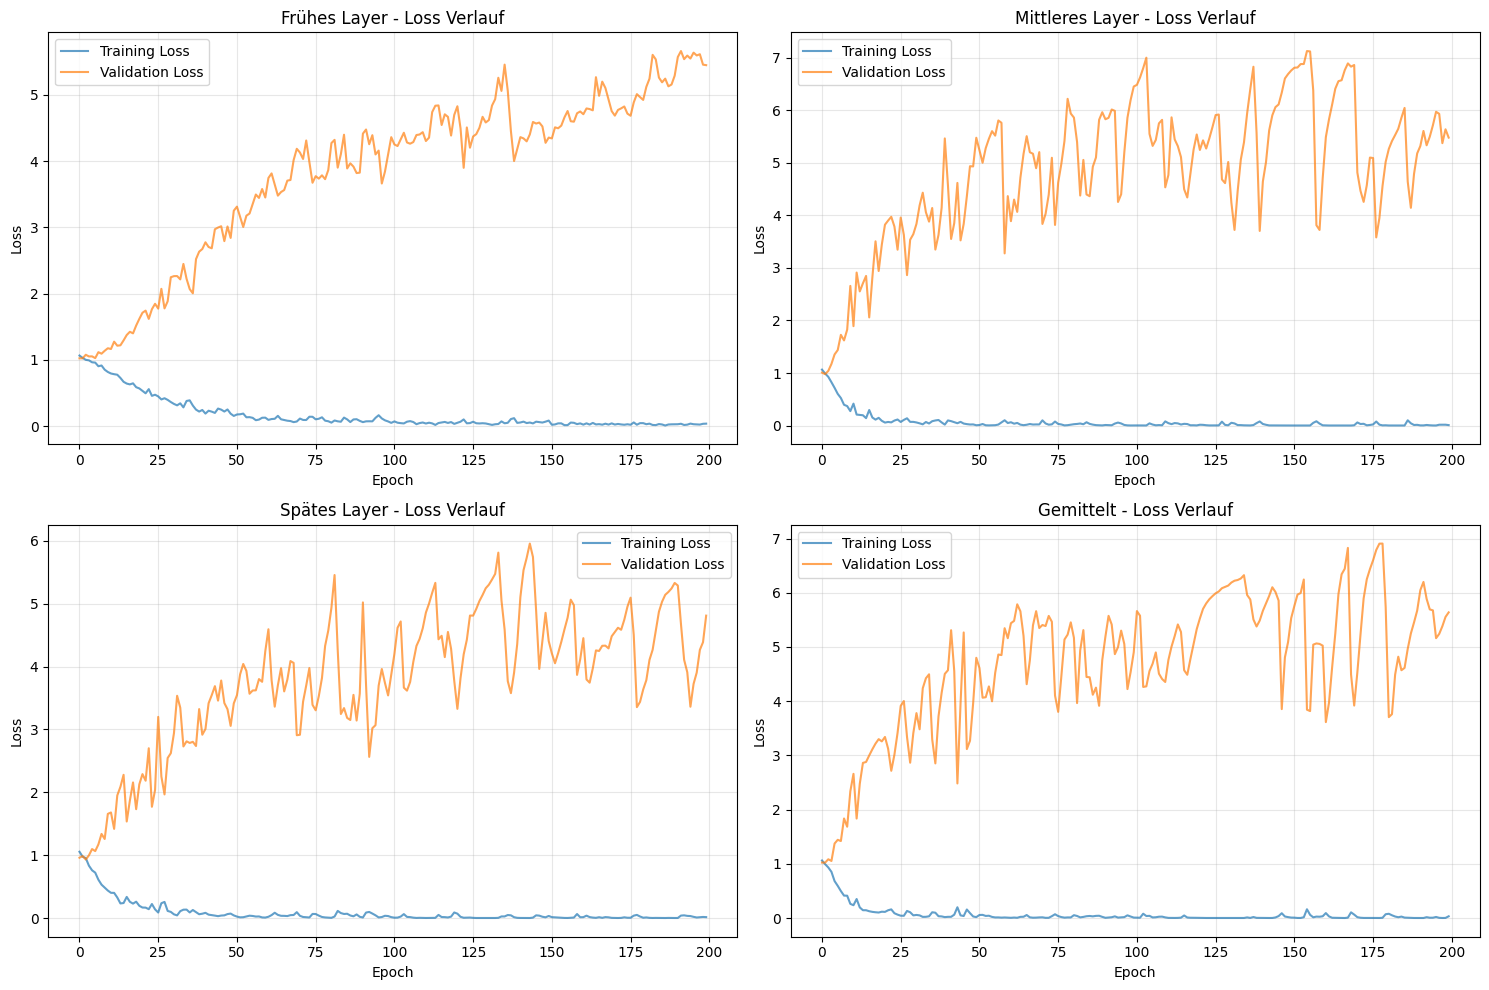

In [35]:
# Training-Verläufe plotten
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    ax = axes[i]

    # Loss-Verlauf
    ax.plot(result['train_losses'], label='Training Loss', alpha=0.7)
    ax.plot(result['val_losses'], label='Validation Loss', alpha=0.7)
    ax.set_title(f'{name} - Loss Verlauf')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()